In [127]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unidecode
from bs4 import BeautifulSoup
from nltk import tokenize, download, ngrams, FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from statsmodels.stats.proportion import proportions_ztest

In [128]:
# Preprocess data
def prepocess_data(rest_file, review_file):
    """"
    A function that reads in the restaurant and review data .csvs, as provided by the notebook data_processing.ipynb

    Input: two file names: rest_file for restaurant information, and review_file for the review information
    Output: df, a combined dataframe of restaurant and review data for NLP analysis
    """
    # Read in restaurant, review data
    rest_data = pd.read_csv(rest_file, index_col=0)
    reviews = pd.read_csv(review_file, index_col=0)

    # Select columns of interest from restaurants
    rest_data = rest_data[['alias', 'price', 'is_michelin']]

    reviews = reviews[['eliteYear', 'localizedDate',
                    'rating', 'comment.text', 'restaurant']]

    # Rename for easy join
    reviews.rename(columns={'restaurant':'alias'}, inplace=True)

    # Merge dataframes
    df = pd.merge(reviews, rest_data, how='inner', on='alias')

    # Rename columns for ease
    df.columns = ['elite_year', 'review_date','rating','review',
                    'alias','price', 'michelin']
    
    # Return dataframe for analyis
    return df

In [129]:
# Test function
test = prepocess_data('restaurant_details.csv', 'restaurant_reviews.csv')

/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_81278/3340729071.py:11: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(review_file, index_col=0)


In [130]:
test.head()

,elite_year,review_date,rating,review,alias,price,michelin
0,NaN,11/2/2018,5.0,*Tartinery is one of the food vendors at Hudso...,tartinery-new-york-15,$$,0
1,NaN,8/6/2023,3.0,Overall the service is very slow. We ordered 2...,tartinery-new-york-15,$$,0
2,2023.0,10/17/2022,4.0,Yum I love a place that has interesting drinks...,tartinery-new-york-15,$$,0
3,2023.0,11/29/2021,5.0,I always look for a comfortable go to bar/rest...,tartinery-new-york-15,$$,0
4,2023.0,4/6/2022,3.0,Tartinery is where you go for happy hour wine ...,tartinery-new-york-15,$$,0


In [131]:
# Function to preprocess the data for analysis
def preprocess_reviews(df):
    """
    A function that cleans the dataframe text for reviews
    """
    # Drop duplicate reviews (use copy to avoid Pandas warning)
    df = df[df['review'].duplicated() == False].copy()

    # Drop no reviews
    df = df[df['review'].str.contains('[a-zA-Z]')]

    # Remove HTML tags from text using Beautiful Soup
    # Why a library over regular expressions? Better edge case handling
    df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' '))) 
    # The warning just means maybe not all contain HTML tags, it's fine. Unidecode to remove non-English chars

    # Remove odd characters, rest seem plausible
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'[{}*\r\\\^#`|]', '', x)) # Hashtags don't work with VADER

    # Remove extra spaces
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Return cleaned dataframe
    return df

In [132]:
test = preprocess_reviews(test)
test.head()

/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_81278/1999102071.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' ')))


,elite_year,review_date,rating,review,alias,price,michelin
0,NaN,11/2/2018,5.0,Tartinery is one of the food vendors at Hudson...,tartinery-new-york-15,$$,0
1,NaN,8/6/2023,3.0,Overall the service is very slow. We ordered 2...,tartinery-new-york-15,$$,0
2,2023.0,10/17/2022,4.0,Yum I love a place that has interesting drinks...,tartinery-new-york-15,$$,0
3,2023.0,11/29/2021,5.0,I always look for a comfortable go to bar/rest...,tartinery-new-york-15,$$,0
4,2023.0,4/6/2022,3.0,Tartinery is where you go for happy hour wine ...,tartinery-new-york-15,$$,0


In [133]:
# Now return what is necessary for the VADER
def run_vader(reviews, downloaded = False, test_method = True):
    """
    Make comments here
    Returns two series for the polarity, or one on user choice
    """

    # If user needs dependencies, download them to run VADER
    if downloaded:
        download('punkt')
        download('vader_lexicon')

    # Get a list for tracking sentiment of each review
    overall_sent = []

    # Get sentiment object
    sid = SentimentIntensityAnalyzer()

    # Get list of reviews
    review_list = list(reviews)

    # Tokenize each review on sentence level, get VADER output for each sentence and take the mean
    for rev in review_list:
        review = tokenize.sent_tokenize(rev)
        rev_sent = []
        # Now for each sentence, get the polarity
        for i in review:
            rev_sent.append(sid.polarity_scores(i)['compound'])
        
        # Stitch mean to list for final output
        overall_sent.append(np.array(rev_sent).mean())

    # If the user wants to compare methodologies, calculate and return both methods
    if test_method:
        rev_sent = []

        # For each sentence, apply VADER to the entire sentence
        for sentence in review_list:
            rev_sent.append(sid.polarity_scores(sentence)['compound'])

        # Return both
        return overall_sent, rev_sent
    
    # Else return just the mean methodology
    return [overall_sent]

In [134]:
tester = run_vader(test['review'])

In [135]:
def analyze_vader(df, sentiment, test_method = True):
    """
    A function that will stitch VADER to the dataframe, and spit out the metrics and visuals
    """

    # If only one element given, test_method is false
    if len(sentiment) < 2:
        test_method = False
    
    # Add sentiment column
    df['polarity'] = sentiment[0]

    # Test correlation of polarity score and rating
    corr_polarity = df['polarity'].corr(df['rating'], method='spearman') # this is good (Spearman for rank data, working with ratings)
    print('The Spearman Rank Correlation between review sentiment and rating (averaging method) is : ' + str(corr_polarity))

    # Perform classification for positive and negative reviews
    df['polarity_class'] = np.nan
    df.loc[df['polarity'] > 0.025, 'polarity_class']  = 'Positive'
    df.loc[df['polarity'] < -0.025, 'polarity_class']  = 'Negative'
    df.loc[((df['polarity'] > -0.025) & (df['polarity'] < 0.025)), 'polarity_class'] = 'Neutral'

    # Aggregate rating distribution for plotting
    # For averaging method
    count_class = df.groupby('polarity_class')['rating'].value_counts(normalize=True).to_frame()
    count_class.sort_index(inplace=True)

    # If the user would like to test the non-averaging method...
    if test_method:
        # Test correlation of polarity score and rating
        df['polarity_total'] = sentiment[1]
        corr_polarity_non = df['polarity_total'].corr(df['rating'], method='spearman') 
        print('The Spearman Rank Correlation between review sentiment and rating (non-averaging method) is : ' + str(corr_polarity_non))

        # Perform classification for postiive and negative scores
        df['polarity_tot_class'] = np.nan
        df.loc[df['polarity_total'] > 0.025, 'polarity_tot_class']  = 'Positive'
        df.loc[df['polarity_total'] < -0.025, 'polarity_tot_class']  = 'Negative'
        df.loc[((df['polarity_total'] > -0.025) & (df['polarity_total'] < 0.025)), 'polarity_tot_class'] = 'Neutral'

        # Plot the distributions (we get better spread)
        fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True)

        ax[0].hist(df['polarity'], bins = 10, color = 'blue')
        ax[0].set_title('Averaging Method')
        ax[0].set_xlabel('Polarity')
        ax[1].hist(df['polarity_total'], bins = 10, color = 'orange')
        ax[1].set_title('Non-Averaging Method')
        ax[1].set_xlabel('Polarity')
        plt.show()

        # See boxplots of polarity on the data
        fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=2, sharey=True, tight_layout=True)

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]
        rating_data_nonavg = [df[df['rating'] == x]['polarity_total'] for x in range(1, int(df['rating'].max() + 1))]

        # We want a boxplot of polarity
        ax[0].boxplot(rating_data_avg)
        ax[1].boxplot(rating_data_nonavg)

        # Subset polarity by ratings
        #ax[0].set_xticks([x + 1 for x in range(len(rating_data_avg))], labels=[str(x+1) for x in range(len(rating_data_avg))])
        ax[0].set_xlabel('Rating')
        ax[0].set_ylabel('Polarity')
        ax[0].set_title('Averaging Method')

        #ax[1].set_xticks([x + 1 for x in range(len(rating_data_nonavg))], labels=[str(x+1) for x in range(len(rating_data_nonavg))])
        ax[1].set_xlabel('Rating')
        ax[1].set_title('Non-Averaging Method')
        plt.show()


        # Plot rating distribution by sentiment class
        # Get rating distribution by class for the non-averaging method
        count_class_non = df.groupby('polarity_tot_class')['rating'].value_counts(normalize=True).to_frame()
        count_class_non.sort_index(inplace=True)

        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = count_class['rating']

        y_non_avg = [str(x) for x in count_class_non.index]
        percentage_non_avg = count_class_non['rating']

        # Generate bar chart
        hbars_avg = axes[0].barh(y_avg, percentage_avg, align='center', color='green', label=percentage_avg)
        hbars_non = axes[1].barh(y_non_avg, percentage_non_avg, align='center', color='red', label=percentage_non_avg)

        axes[0].set_yticks(y_avg)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        axes[0].set_xlabel('Percentage')
        axes[0].set_ylabel('Review Class')
        axes[0].set_title('Averaging Method')

        axes[1].set_yticks(y_non_avg)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_non, labels=[round(x, 2) for x in percentage_non_avg])
        axes[1].set_xlabel('Percentage')
        axes[1].set_ylabel('Review Class')
        axes[1].set_title('Non-Averaging Method')

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding
        plt.show()

        # Trim class for final dataframe
        df.drop(['polarity_total', 'polarity_tot_class'], axis=1, inplace=True)
        
    else:
        # Plot only the averaging method
        fig, ax = plt.subplots()
        ax.hist(df['polarity'], bins = 10, color = 'blue')
        ax.set_title('Averaging Method')
        ax.set_xlabel('Polarity')
        plt.show()

        # See boxplots of polarity on the data
        fig, ax = plt.subplots(figsize=(8, 8))

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]
        print(len(rating_data_avg), rating_data_avg.index)

        # We want a boxplot of polarity
        ax.boxplot(rating_data_avg)

        # Subset polarity by ratings
        ax.set_xticks([x + 1 for x in range(len(rating_data_avg))], labels=[str(x+1) for x in range(len(rating_data_avg))])
        ax.set_xlabel('Rating')
        ax.set_ylabel('Polarity')
        ax.set_title('Averaging Method')
        plt.show()

        # Plot rating distribution by sentiment class
        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(figsize=(10, 6))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = count_class['rating']

        # Generate bar chart
        hbars_avg = axes.barh(y_avg, percentage_avg, align='center', color='green', label=percentage_avg)

        axes.set_yticks(y_avg)
        axes.invert_yaxis() # Invert to show top first
        axes.bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        axes.set_xlabel('Percentage')
        axes.set_ylabel('Review Class')
        axes.set_title('Averaging Method')
        plt.show()

    # Return dataframe, and list of plots
    return df

The Spearman Rank Correlation between review sentiment and rating (averaging method) is : 0.6342233092246284


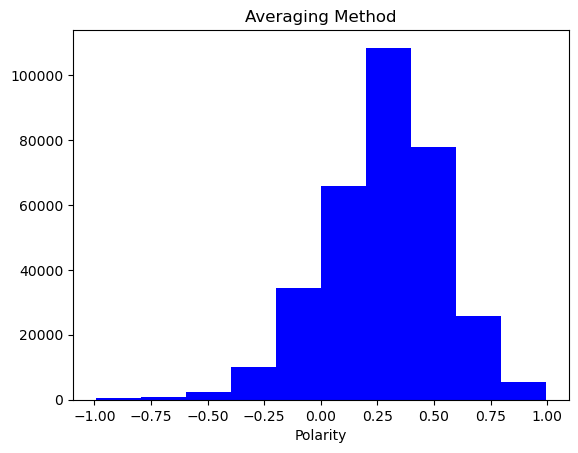

5 <built-in method index of list object at 0x2bf6f71c0>


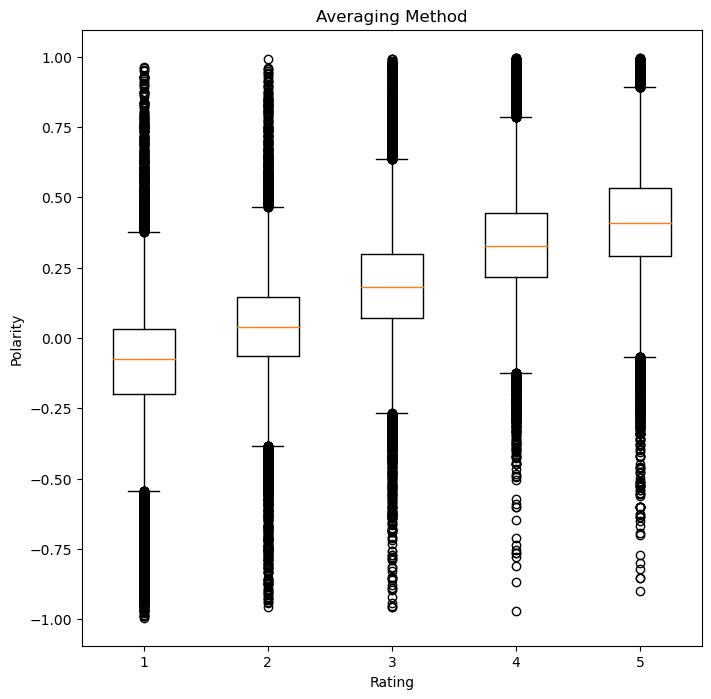

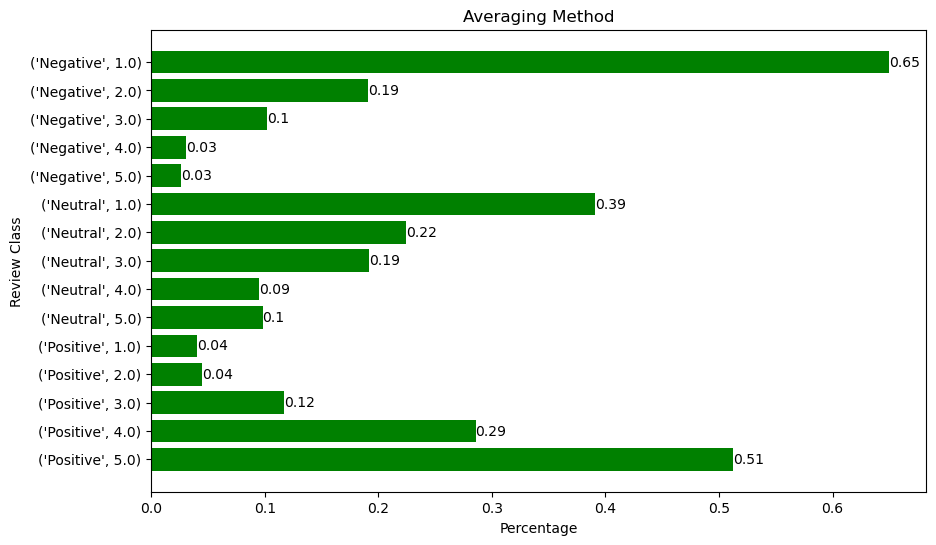

In [136]:
test = analyze_vader(test, tester, False)

The Spearman Rank Correlation between review sentiment and rating (averaging method) is : 0.6342233092246284
The Spearman Rank Correlation between review sentiment and rating (non-averaging method) is : 0.5098203560395118


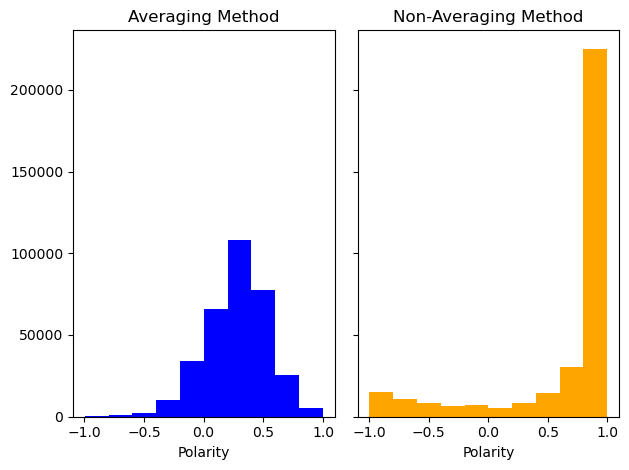

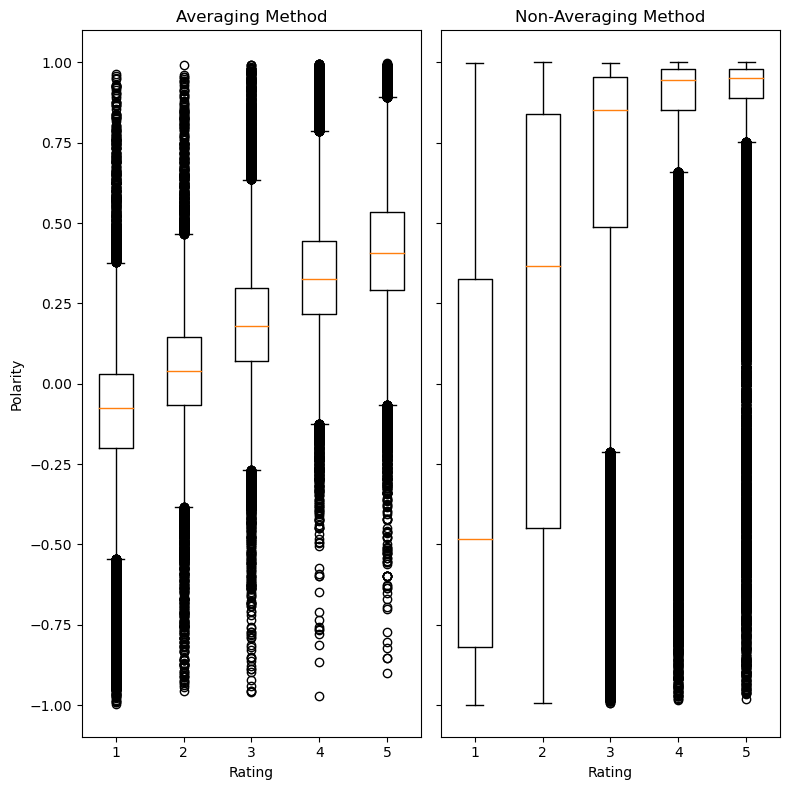

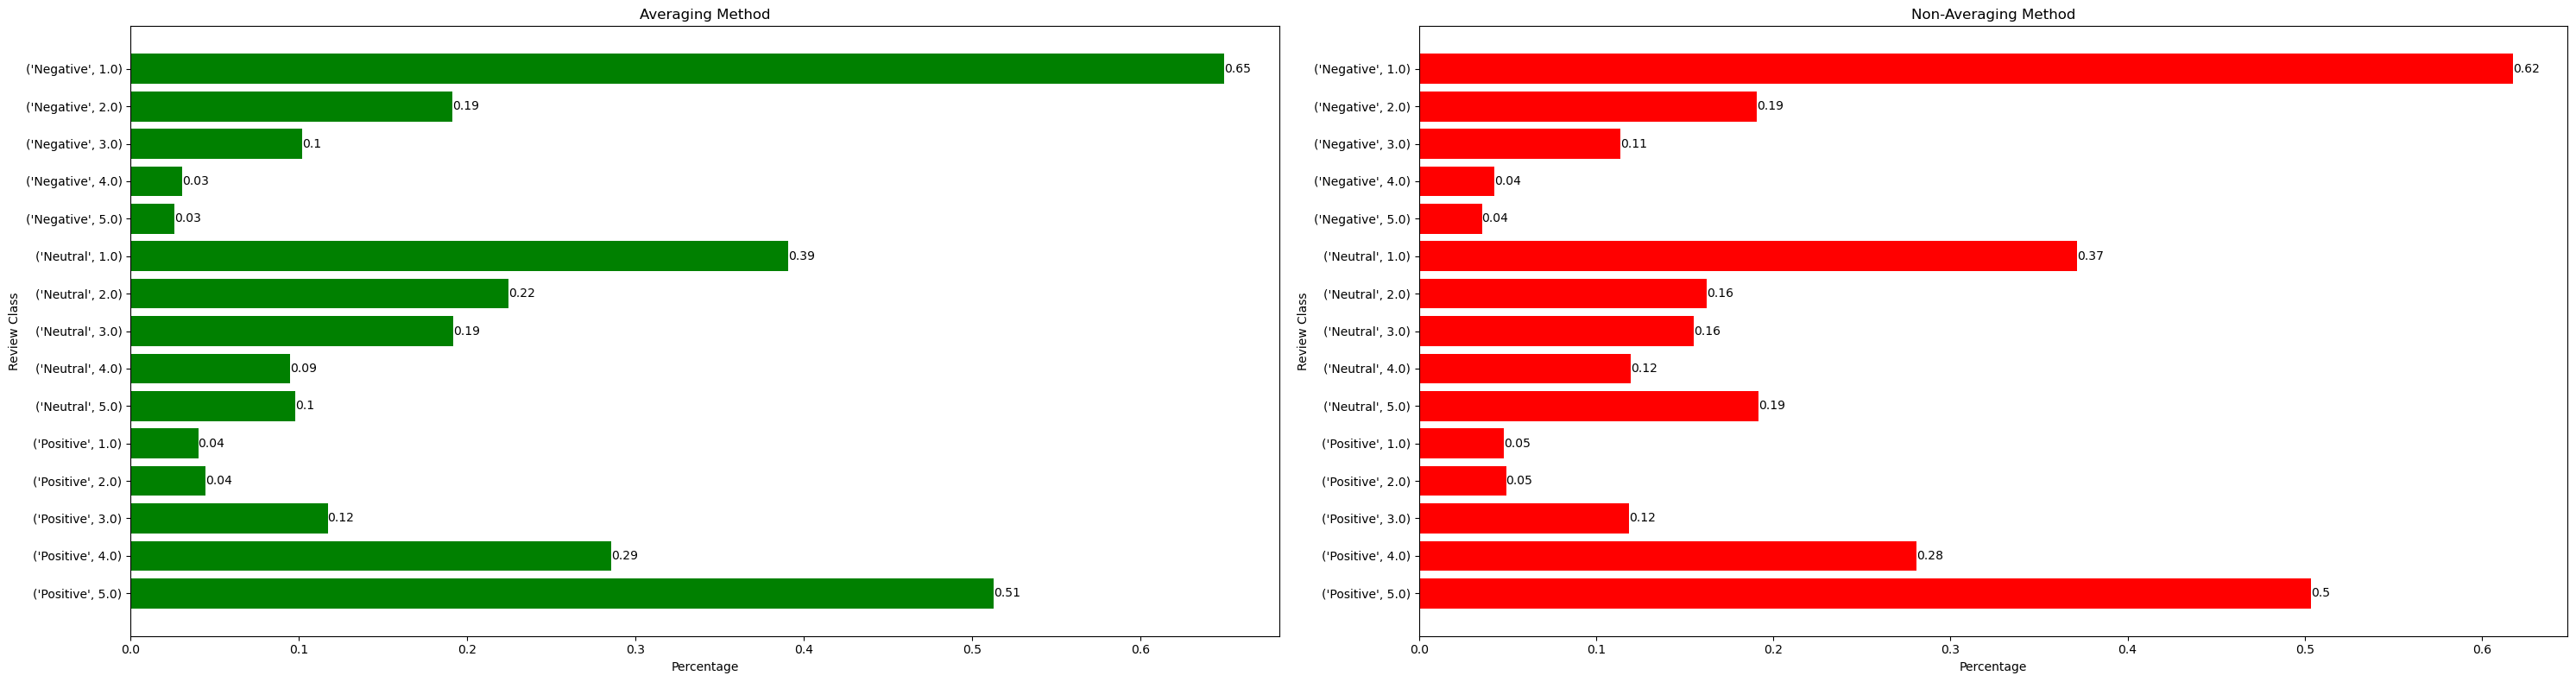

In [137]:
test = analyze_vader(test, tester, True)

In [138]:
def process_text(df, column, downloaded = False, sent_class = False, words = []):
    # A function to help with processing text, so we do not return big strings
    if downloaded:
        # Download stopwords if user has not already downloaded them
        download('stopwords')

    if not sent_class:
        # Filter dataframe based on column of interest
        truth = df['review'].loc[df[column] == True]
        false = df['review'].loc[df[column] == False]

        # Join reviews as one string, remove the stopwords
        stop_words = stopwords.words('english')

        # Update stopwords if needed
        stop_words.append(words)

        # Remove punctuation, make lowercase
        review_truth = truth.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
        review_false = false.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())

        # Tokenize the text and join it as one string in the series
        review_truth = review_truth.apply(lambda x: word_tokenize(x))
        review_false = review_false.apply(lambda x: word_tokenize(x))

        # Flatten lists
        review_truth = review_truth.apply(lambda x:' '.join(x))
        review_false = review_false.apply(lambda x:' '.join(x))

        # Remove stopwords from tokens
        review_truth = review_truth.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
        review_false = review_false.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

        # Join as one string for the word cloud
        review_truth = ' '.join(review_truth)
        review_false = ' '.join(review_false)

        return review_truth, review_false

    # Filter dataframe based on column of interest
    truth_pos = df['review'].loc[(df[column] == True) & (df['polarity_class'] == 'Positive')]
    truth_neg = df['review'].loc[(df[column] == True) & (df['polarity_class'] == 'Negative')]
    false_pos = df['review'].loc[(df[column] == False) & (df['polarity_class'] == 'Positive')]
    false_neg = df['review'].loc[(df[column] == False) & (df['polarity_class'] == 'Negative')]

    # Join reviews as one string, remove the stopwords
    stop_words = stopwords.words('english')

    # Update stopwords if needed
    stop_words.append(words)

    # Remove punctuation, make lowercase
    review_truth_pos = truth_pos.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_truth_neg = truth_neg.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_false_pos = false_pos.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())
    review_false_neg = false_neg.apply(lambda x: re.sub(r'[^\w\s]', '', x).lower())

    # Tokenize the text and join it as one string in the series
    review_truth_pos = review_truth_pos.apply(lambda x: word_tokenize(x))
    review_truth_neg = review_truth_neg.apply(lambda x: word_tokenize(x))
    review_false_pos = review_false_pos.apply(lambda x: word_tokenize(x))
    review_false_neg = review_false_neg.apply(lambda x: word_tokenize(x))

    # Flatten lists
    review_truth_pos = review_truth_pos.apply(lambda x:' '.join(x))
    review_truth_neg = review_truth_neg.apply(lambda x:' '.join(x))
    review_false_pos = review_false_pos.apply(lambda x:' '.join(x))
    review_false_neg = review_false_neg.apply(lambda x:' '.join(x))

    # Remove stopwords from tokens
    review_truth_pos = review_truth_pos.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_truth_neg = review_truth_neg.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_false_pos = review_false_pos.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    review_false_neg = review_false_neg.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    # Join as one string for the word cloud
    review_truth_pos = ' '.join(review_truth_pos)
    review_truth_neg = ' '.join(review_truth_neg)
    review_false_pos = ' '.join(review_false_pos)
    review_false_neg = ' '.join(review_false_neg)

    return review_truth_pos, review_truth_neg, review_false_pos, review_false_neg

In [139]:
# Now get the word cloud stuff
def generate_word_clouds(df, column, downloaded = False, sent_class = False, words = []):
    """
    Add notes here
    TODO: Tune stop words, fig size
    """

    # Generate split data
    text_data = process_text(df, column, downloaded, sent_class, words)

    if not sent_class:
        # Create the word cloud
        review_cloud_truth = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[0])
        review_cloud_false = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[1])

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

        axes[0].set_title('Word Cloud of ' + str.capitalize(column) + ' Reviews')
        axes[0].imshow(review_cloud_truth)
        axes[0].axis('off')
        axes[1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Reviews')
        axes[1].imshow(review_cloud_false)
        axes[1].axis('off')
    
    # If the user wants the breakdown by sentiment class
    else:
        # Create the word clouds
        review_cloud_truth_pos = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[0])
        review_cloud_truth_neg = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[1])
        review_cloud_false_pos = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[2])
        review_cloud_false_neg = WordCloud(max_words=50, collocations=False, background_color='white', margin=0).generate(text_data[3])

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

        axes[0, 0].set_title('Word Cloud of ' + str.capitalize(column) + ' Amongst Positive Reviews')
        axes[0, 0].imshow(review_cloud_truth_pos)
        axes[0, 0].axis('off')
        axes[0, 1].set_title('Word Cloud of ' + str.capitalize(column) + ' Amongst Negative Reviews')
        axes[0, 1].imshow(review_cloud_truth_neg)
        axes[0, 1].axis('off')
        axes[1, 0].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Amongst Positive Reviews')
        axes[1, 0].imshow(review_cloud_false_pos)
        axes[1, 0].axis('off')
        axes[1, 1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Amongst Negative Reviews')
        axes[1, 1].imshow(review_cloud_false_neg)
        axes[1, 1].axis('off')

    return plt.show()

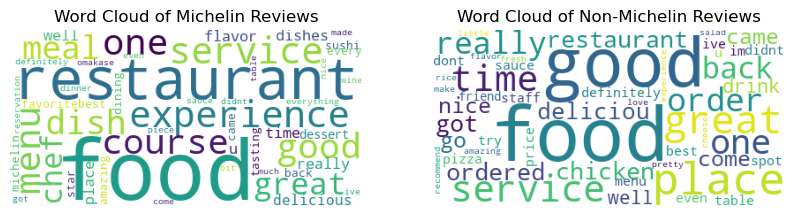

In [140]:
generate_word_clouds(test, 'michelin', words=['i', 'the', 'food', 'restaurant'])

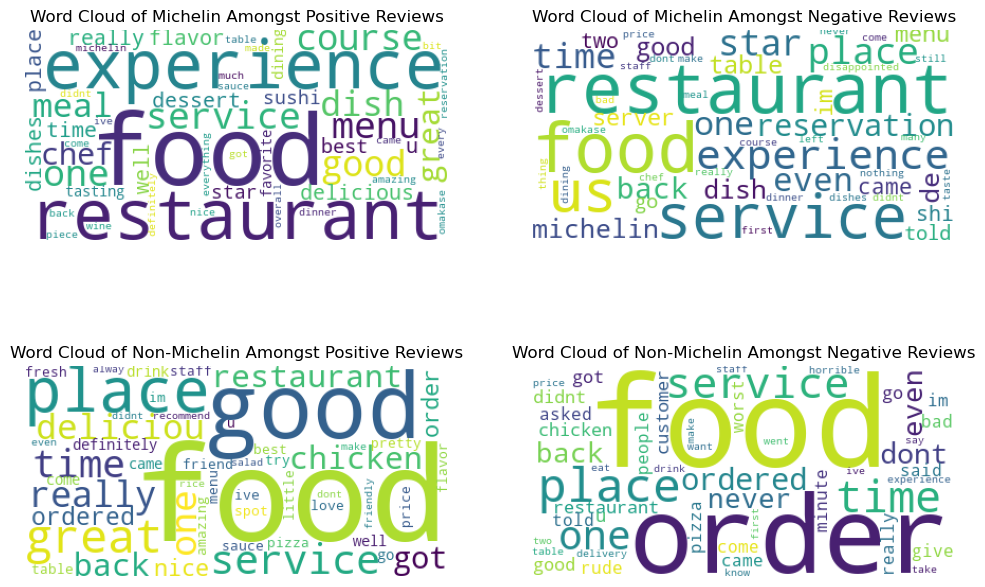

In [141]:
generate_word_clouds(test, 'michelin', words=['i', 'the', 'food', 'restaurant'], sent_class=True)

In [142]:
# Now get the top word analysis
def word_freq_plot(text_list, column_name):
    
    # If no class was selected, proceed on the binary column
    if(len(text_list) == 2):
        # Get truth text
        word_freq_truth_total = pd.Series(text_list[0].split())

        # Get frequency dataframe
        word_freq_truth = word_freq_truth_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_truth.columns = ['Word', 'Frequency']
        word_freq_truth['Percentage'] = round((100*word_freq_truth['Frequency'] / len(word_freq_truth_total)), 3)

        # Get false text
        word_freq_false_total = pd.Series(text_list[1].split())

        # Get frequency dataframe
        word_freq_false = word_freq_false_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
        word_freq_false.columns = ['Word', 'Frequency']

        word_freq_false['Percentage'] = round((100*word_freq_false['Frequency'] / len(word_freq_false_total)), 3)
        word_freq_false.head()

        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

        # Get top 10 for each case
        word_freq_truth_10 = word_freq_truth[:10]
        word_freq_false_10 = word_freq_false[:10]

        # Get the x, y axes
        y_t = word_freq_truth_10['Word']
        percentage_t = word_freq_truth_10['Percentage']

        y_f = word_freq_false_10['Word']
        percentage_f = word_freq_false_10['Percentage']

        # Generate bar chart
        hbars_t = axes[0].barh(y_t, percentage_t, align='center', color='green', label=percentage_t)
        hbars_f = axes[1].barh(y_f, percentage_f, align='center', color='red', label=percentage_f)

        axes[0].set_yticks(y_t)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_t, labels=[x for x in percentage_t])
        axes[0].set_xlabel('Percentage')
        axes[0].set_ylabel('Word')
        axes[0].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth)))

        axes[1].set_yticks(y_f)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_f, labels=[x for x in percentage_f])
        axes[1].set_xlabel('Percentage')
        axes[1].set_ylabel('Word')
        axes[1].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Reviews (Top 10). # Tokens = ' + str(len(word_freq_false)))

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        # Return plot, truth words for downstream tasks
        return plt.show()
    
    # If class was selected, get a 2x2 of word frequencies
    # Get truth text, positive reviews
    word_freq_truth_pos_total = pd.Series(text_list[0].split())

    # Get frequency dataframe
    word_freq_truth_pos = word_freq_truth_pos_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_truth_pos.columns = ['Word', 'Frequency']
    word_freq_truth_pos['Percentage'] = round((100*word_freq_truth_pos['Frequency'] / len(word_freq_truth_pos_total)), 3)

    # Get truth text, negative reviews
    word_freq_truth_neg_total = pd.Series(text_list[1].split())

    # Get frequency dataframe
    word_freq_truth_neg = word_freq_truth_neg_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_truth_neg.columns = ['Word', 'Frequency']
    word_freq_truth_neg['Percentage'] = round((100*word_freq_truth_neg['Frequency'] / len(word_freq_truth_neg_total)), 3)

    # Get false text, postive reviews
    word_freq_false_pos_total = pd.Series(text_list[2].split())

    # Get frequency dataframe
    word_freq_false_pos = word_freq_false_pos_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_false_pos.columns = ['Word', 'Frequency']

    word_freq_false_pos['Percentage'] = round((100*word_freq_false_pos['Frequency'] / len(word_freq_false_pos_total)), 3)
    word_freq_false_pos.head()

    # Get false text, negative reviews
    word_freq_false_neg_total = pd.Series(text_list[3].split())

    # Get frequency dataframe
    word_freq_false_neg = word_freq_false_neg_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_false_neg.columns = ['Word', 'Frequency']

    word_freq_false_neg['Percentage'] = round((100*word_freq_false_neg['Frequency'] / len(word_freq_false_neg_total)), 3)
    word_freq_false_neg.head()

    # Show bar chart (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

    # Get top 10 for each case
    word_freq_truth_10_pos = word_freq_truth_pos[:10]
    word_freq_truth_10_neg = word_freq_truth_neg[:10]
    word_freq_false_10_pos = word_freq_false_pos[:10]
    word_freq_false_10_neg = word_freq_false_neg[:10]

    # Get the x, y axes
    y_tp = word_freq_truth_10_pos['Word']
    percentage_tp = word_freq_truth_10_pos['Percentage']

    y_tn = word_freq_truth_10_neg['Word']
    percentage_tn = word_freq_truth_10_neg['Percentage']

    y_fp = word_freq_false_10_pos['Word']
    percentage_fp = word_freq_false_10_pos['Percentage']

    y_fn = word_freq_false_10_neg['Word']
    percentage_fn = word_freq_false_10_neg['Percentage']

    # Generate bar chart
    hbars_tp = axes[0, 0].barh(y_tp, percentage_tp, align='center', color='green', label=percentage_tp)
    hbars_tn = axes[1, 0].barh(y_tn, percentage_tn, align='center', color='green', label=percentage_tn)
    hbars_fp = axes[0, 1].barh(y_fp, percentage_fp, align='center', color='red', label=percentage_fp)
    hbars_fn = axes[1, 1].barh(y_fn, percentage_fn, align='center', color='red', label=percentage_fn)

    axes[0, 0].set_yticks(y_tp)
    axes[0, 0].invert_yaxis() # Invert to show top first
    axes[0, 0].bar_label(hbars_tp, labels=[x for x in percentage_tp])
    axes[0, 0].set_xlabel('Percentage')
    axes[0, 0].set_ylabel('Word')
    axes[0, 0].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth_pos)))

    axes[1, 0].set_yticks(y_tn)
    axes[1, 0].invert_yaxis() # Invert to show top first
    axes[1, 0].bar_label(hbars_tn, labels=[x for x in percentage_tn])
    axes[1, 0].set_xlabel('Percentage')
    axes[1, 0].set_ylabel('Word')
    axes[1, 0].set_title('Frequency of Words in ' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10). # Tokens = ' + str(len(word_freq_truth_neg)))

    axes[0, 1].set_yticks(y_fp)
    axes[0, 1].invert_yaxis() # Invert to show top first
    axes[0, 1].bar_label(hbars_fp, labels=[x for x in percentage_fp])
    axes[0, 1].set_xlabel('Percentage')
    axes[0, 1].set_ylabel('Word')
    axes[0, 1].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10). # Tokens = ' + str(len(word_freq_false_pos)))

    axes[1, 1].set_yticks(y_fn)
    axes[1, 1].invert_yaxis() # Invert to show top first
    axes[1, 1].bar_label(hbars_fn, labels=[x for x in percentage_fn])
    axes[1, 1].set_xlabel('Percentage')
    axes[1, 1].set_ylabel('Word')
    axes[1, 1].set_title('Frequency of Words in Non-' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10). # Tokens = ' + str(len(word_freq_false_neg)))


    fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

    # Return plot
    return plt.show()

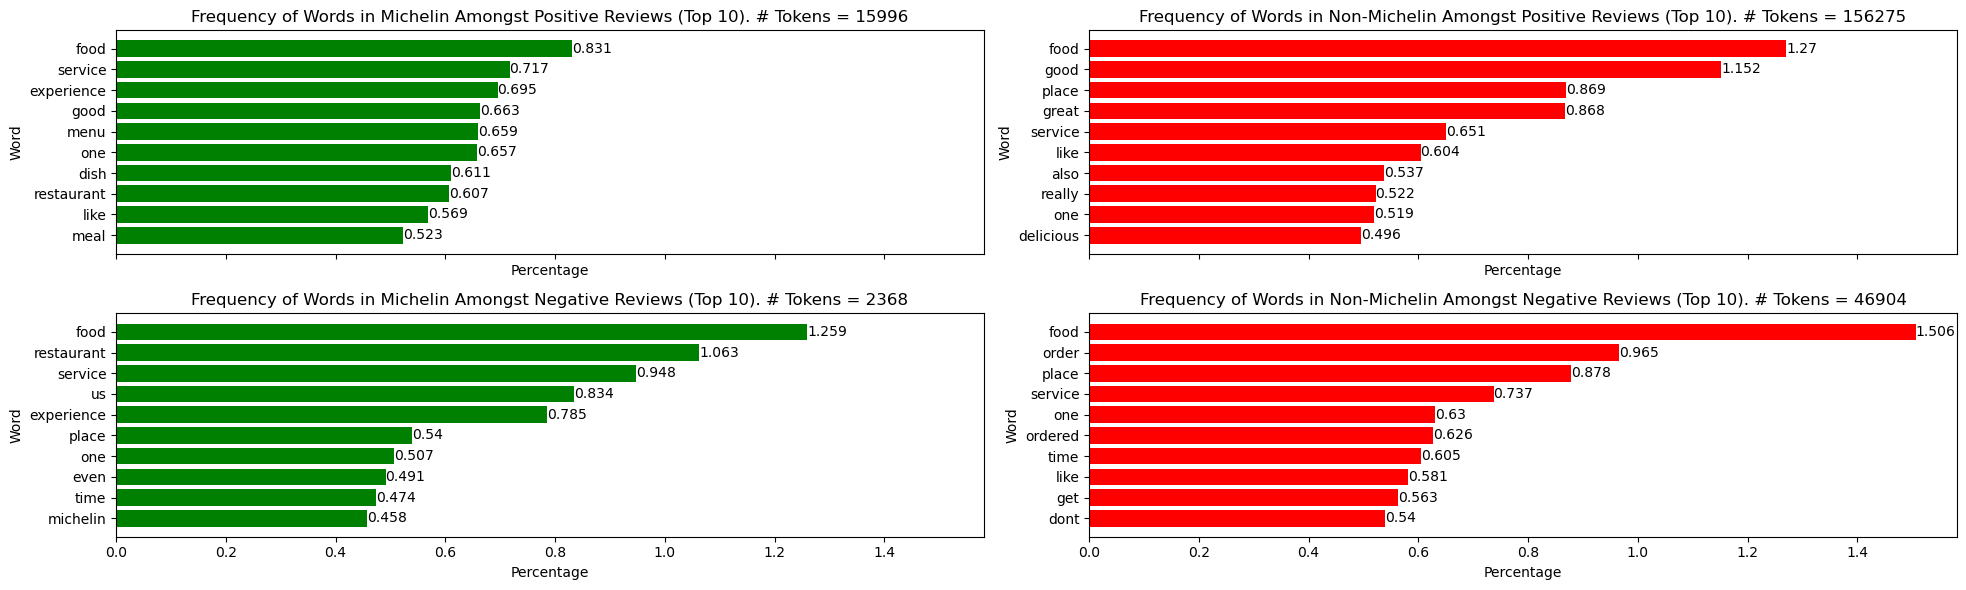

In [143]:
# Test it
word_freq_plot(process_text(test, 'michelin', words=['i', 'the', 'food', 'restaurant'], sent_class=True), 'michelin')

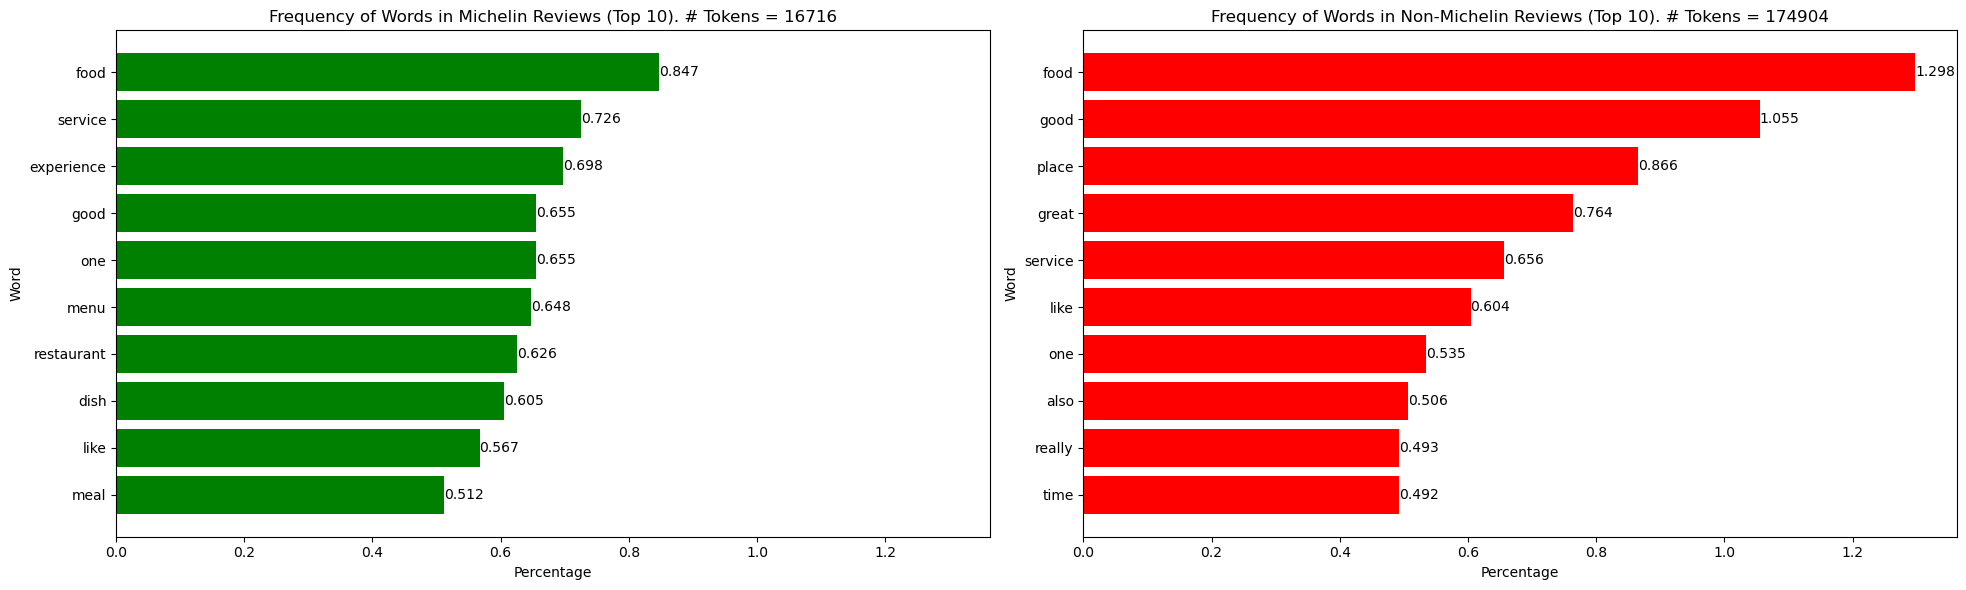

In [144]:
word_freq_plot(process_text(test, 'michelin', words=['i', 'the', 'food', 'restaurant'], sent_class=False), 'michelin')

In [145]:
def word_sig_test(text_list):
    # If against a truth column, among pos/neg for that
    # Otherwise compare across binary column
    review_text = text_list[0] + ' ' + text_list[1]

    # Get a dataframe of the population values
    word_freq_total = pd.Series(review_text.split())

    # Get into a dataframe
    word_freq = word_freq_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq.columns = ['Word', 'Frequency_Pop']

    # Ok, now do it for the column of interest
    word_freq_truth_total = pd.Series(text_list[0].split())

    # Get dataframe
    word_freq_truth = word_freq_truth_total.value_counts().sort_values(ascending=False).to_frame().reset_index()
    word_freq_truth.columns = ['Word', 'Frequency']

    # Now use dictionary structure get the data for the truth case
    test = pd.merge(word_freq_truth, word_freq, on='Word')

    # Now see if there are significant results
    sig_list = []

    # Get sample sizes
    truth_size = len(word_freq_truth_total)
    pop_size = len(word_freq_total)

    # Run the test for all values in our dataframe
    for index, val in test.iterrows():
        # Get successes
        truth = val['Frequency']
        pop = val['Frequency_Pop']

        # Conduct the test - this is not working
        p_val = proportions_ztest(np.array([truth, pop]), np.array([truth_size, pop_size]), alternative='larger')[1]

        if p_val < 0.01:
            sig_list.append(index)

    # Return matches with top words
    return word_freq_truth.loc[sig_list[0:10]]

In [146]:
test_ws = word_sig_test(process_text(test, 'michelin', words=['i', 'the', 'food', 'restaurant'], sent_class=False))
test_ws

,Word,Frequency
1,service,1865
2,experience,1792
4,one,1682
5,menu,1664
6,restaurant,1608
7,dish,1553
9,meal,1315
13,course,1197
15,dishes,1102
16,us,1068


In [147]:
test_ws = word_sig_test(process_text(test, 'michelin', words=['i', 'the', 'food', 'restaurant'], sent_class=True))
test_ws # Makes sense, only 96 negative reviews - wouldn't be much different from the population

,Word,Frequency


In [148]:
def process_ngrams(text_list, n_grams=2):

    # If no class was selected, proceed on the binary column
    if (len(text_list) == 2):

        review_text = pd.Series((text_list[0] + ' ' + text_list[1]).split())
        truth_text = pd.Series(text_list[0].split())
        false_text = pd.Series(text_list[1].split())
        
        # Generate list of n_grams
        n_grams_total = list(ngrams(review_text, n_grams))
        n_grams_truth = list(ngrams(truth_text, n_grams))
        n_grams_false = list(ngrams(false_text, n_grams))

        # Feed into NLTK Freq Dist
        freq_dist_total = FreqDist(n_grams_total)
        freq_dist_truth = FreqDist(n_grams_truth)
        freq_dist_false = FreqDist(n_grams_false)
        
        # Get top n-grams into a dataframe
        ngram_df_total = pd.DataFrame(freq_dist_total.most_common(),
                                columns=['Ngram', 'Frequency_Pop'])

        ngram_df_total['Ngram'] = ngram_df_total['Ngram'].apply(' '.join)
        ngram_df_total['Percentage'] = round(100*ngram_df_total['Frequency_Pop'] / len(n_grams_total), 3)

        # Truth case
        ngram_df_truth = pd.DataFrame(freq_dist_truth.most_common(10),
                                columns=['Ngram', 'Frequency'])

        ngram_df_truth['Ngram'] = ngram_df_truth['Ngram'].apply(' '.join)
        ngram_df_truth['Percentage'] = round(100*ngram_df_truth['Frequency'] / len(n_grams_truth), 3)

        # False case
        ngram_df_false = pd.DataFrame(freq_dist_false.most_common(10),
                                columns=['Ngram', 'Frequency'])

        ngram_df_false['Ngram'] = ngram_df_false['Ngram'].apply(' '.join)
        ngram_df_false['Percentage'] = round(100*ngram_df_false['Frequency'] / len(n_grams_false), 3)
    
        # Return information for downstream tasks
        return ngram_df_truth, ngram_df_false, ngram_df_total

    # Else return by class case
    # Split text string
    total_pos = pd.Series((text_list[0] + ' ' + text_list[1]).split())
    truth_pos = pd.Series(text_list[0].split())
    truth_neg = pd.Series(text_list[1].split())
    false_pos = pd.Series(text_list[2].split())
    false_neg = pd.Series(text_list[3].split())

    # Generate list of n_grams
    n_grams_total_pos = list(ngrams(total_pos, n_grams))
    n_grams_truth_pos = list(ngrams(truth_pos, n_grams))
    n_grams_truth_neg = list(ngrams(truth_neg, n_grams))
    n_grams_false_pos = list(ngrams(false_pos, n_grams))
    n_grams_false_neg = list(ngrams(false_neg, n_grams))

    # Feed into NLTK Freq Dist
    freq_dist_total_pos = FreqDist(n_grams_total_pos)
    freq_dist_truth_pos = FreqDist(n_grams_truth_pos)
    freq_dist_truth_neg = FreqDist(n_grams_truth_neg)
    freq_dist_false_pos = FreqDist(n_grams_false_pos)
    freq_dist_false_neg = FreqDist(n_grams_false_neg)

    # Get top n-grams into a dataframe
    ngram_df_total_pos = pd.DataFrame(freq_dist_total_pos.most_common(),
                            columns=['Ngram', 'Frequency_Pop'])

    ngram_df_total_pos['Ngram'] = ngram_df_total_pos['Ngram'].apply(' '.join)
    ngram_df_total_pos['Percentage'] = round(100*ngram_df_total_pos['Frequency_Pop'] / len(n_grams_total_pos), 3)

    # Truth case
    ngram_df_truth_pos = pd.DataFrame(freq_dist_truth_pos.most_common(10),
                            columns=['Ngram', 'Frequency'])

    ngram_df_truth_pos['Ngram'] = ngram_df_truth_pos['Ngram'].apply(' '.join)
    ngram_df_truth_pos['Percentage'] = round(100*ngram_df_truth_pos['Frequency'] / len(n_grams_truth_pos), 3)

    ngram_df_truth_neg = pd.DataFrame(freq_dist_truth_neg.most_common(10),
                        columns=['Ngram', 'Frequency'])

    ngram_df_truth_neg['Ngram'] = ngram_df_truth_neg['Ngram'].apply(' '.join)
    ngram_df_truth_neg['Percentage'] = round(100*ngram_df_truth_neg['Frequency'] / len(n_grams_truth_neg), 3)

    # False case
    ngram_df_false_pos = pd.DataFrame(freq_dist_false_pos.most_common(10),
                            columns=['Ngram', 'Frequency'])

    ngram_df_false_pos['Ngram'] = ngram_df_false_pos['Ngram'].apply(' '.join)
    ngram_df_false_pos['Percentage'] = round(100*ngram_df_false_pos['Frequency'] / len(n_grams_false_pos), 3)

    ngram_df_false_neg = pd.DataFrame(freq_dist_false_neg.most_common(10),
                        columns=['Ngram', 'Frequency'])

    ngram_df_false_neg['Ngram'] = ngram_df_false_neg['Ngram'].apply(' '.join)
    ngram_df_false_neg['Percentage'] = round(100*ngram_df_false_neg['Frequency'] / len(n_grams_false_neg), 3)

    # Return information for downstream tasks
    return ngram_df_truth_pos, ngram_df_truth_neg, ngram_df_false_pos, ngram_df_false_neg, ngram_df_total_pos

In [149]:
test_ng_nc = process_ngrams(process_text(test, 'michelin', words=['i', 'the', 'york'], sent_class=False))

In [150]:
test_ng_c = process_ngrams(process_text(test, 'michelin', words=['i', 'the', 'york'], sent_class=True))

In [151]:
# Now get ngram word clouds
def generate_word_clouds_ngrams(df, column, downloaded = False, sent_class = False, words = []):
    
    # Generate ngrams data
    ngram_data = process_ngrams(process_text(df, column, downloaded, sent_class, words))

    if not sent_class:

        # Get as dictionaries for frequencies
        ngram_truth = ngram_data[0][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false = ngram_data[1][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']

        # Create the word cloud
        review_cloud_truth = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth)
        review_cloud_false = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false)

        # Add matplotlib capability
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

        axes[0].set_title('Word Cloud of ' + str.capitalize(column) + ' Review Ngrams')
        axes[0].imshow(review_cloud_truth)
        axes[0].axis('off')
        axes[1].set_title('Word Cloud of Non-' + str.capitalize(column) + ' Review Ngrams')
        axes[1].imshow(review_cloud_false)
        axes[1].axis('off')
    
    # Else if the user wants the breakdown by sentiment class
    else:
        # Get as dictionaries for frequencies
        ngram_truth_pos = ngram_data[0][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_truth_neg = ngram_data[1][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false_pos = ngram_data[2][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']
        ngram_false_neg = ngram_data[3][['Ngram', 'Frequency']].set_index('Ngram').to_dict()['Frequency']

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
        review_cloud_truth_pos = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth_pos)
        review_cloud_truth_neg = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_truth_neg)
        review_cloud_false_pos = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false_pos)
        review_cloud_false_neg = WordCloud(collocations=False, background_color='white', margin=0).generate_from_frequencies(ngram_false_neg)

        axes[0, 0].set_title('Cloud of ' + str.capitalize(column) + ' Ngrams Amongst Positive Reviews')
        axes[0, 0].imshow(review_cloud_truth_pos)
        axes[0, 0].axis('off')
        axes[1, 0].set_title('Cloud of ' + str.capitalize(column) + ' Ngrams Amongst Negative Reviews')
        axes[1, 0].imshow(review_cloud_truth_neg)
        axes[1, 0].axis('off')
        axes[0, 1].set_title('Cloud of Non-' + str.capitalize(column) + ' Ngrams Amongst Positive Reviews')
        axes[0, 1].imshow(review_cloud_false_pos)
        axes[0, 1].axis('off')
        axes[1, 1].set_title('Cloud of Non-' + str.capitalize(column) + ' Ngrams Amongst Negative Reviews')
        axes[1, 1].imshow(review_cloud_false_neg)
        axes[1, 1].axis('off')

    return plt.show()

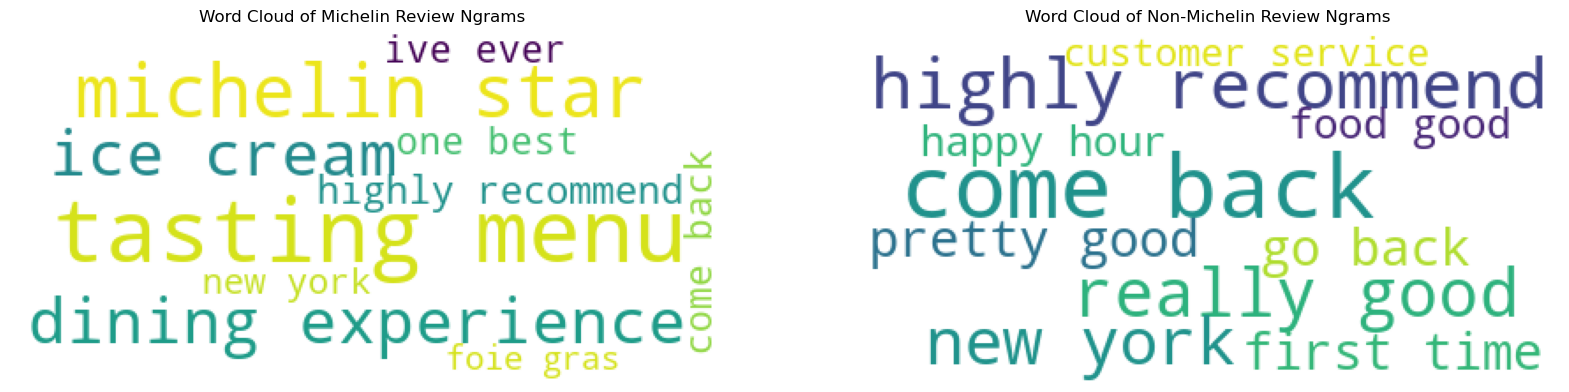

In [152]:
generate_word_clouds_ngrams(test, 'michelin', words=['i', 'the', 'york'])

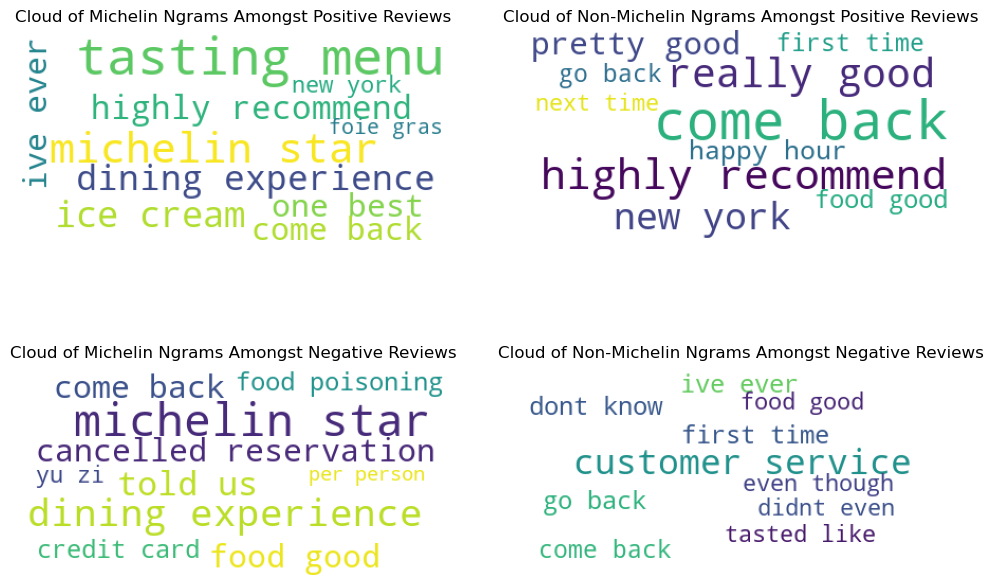

In [153]:
generate_word_clouds_ngrams(test, 'michelin', sent_class=True, words=['i', 'the', 'york'])

In [154]:
# Write function to return the bar charts
def ngram_freq_plot(freq_dfs, column_name):

    # If no class selected, run on the binary case
    if len(freq_dfs) == 3:
        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

        # Extract information for plots
        ngram_df_truth = freq_dfs[0]
        ngram_df_false = freq_dfs[1]

        # Get the x, y axes
        y_t = ngram_df_truth['Ngram']
        percentage_t = ngram_df_truth['Percentage']

        y_f = ngram_df_false['Ngram']
        percentage_f = ngram_df_false['Percentage']

        # Generate bar chart
        hbars_t = axes[0].barh(y_t, percentage_t, align='center', color='green', label=percentage_t)
        hbars_f = axes[1].barh(y_f, percentage_f, align='center', color='red', label=percentage_f)

        axes[0].set_yticks(y_t)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_t, labels=[x for x in percentage_t])
        axes[0].set_xlabel('Percentage')
        axes[0].set_ylabel('Ngram')
        axes[0].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + '  Reviews (Top 10)')

        axes[1].set_yticks(y_f)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_f, labels=[x for x in percentage_f])
        axes[1].set_xlabel('Percentage')
        axes[1].set_ylabel('Ngram')
        axes[1].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Reviews (Top 10)')

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        return plt.show()
    
    # Else report these across classes
    else:
        # Show bar chart (2x2)
        fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

        # Extract information for plots
        ngram_df_truth_pos = freq_dfs[0]
        ngram_df_truth_neg = freq_dfs[1]
        ngram_df_false_pos = freq_dfs[2]
        ngram_df_false_neg = freq_dfs[3]

        # Get the x, y axes
        y_tp = ngram_df_truth_pos['Ngram']
        percentage_tp = ngram_df_truth_pos['Percentage']

        y_tn = ngram_df_truth_neg['Ngram']
        percentage_tn = ngram_df_truth_neg['Percentage']

        y_fp = ngram_df_false_pos['Ngram']
        percentage_fp = ngram_df_false_pos['Percentage']

        y_fn = ngram_df_false_neg['Ngram']
        percentage_fn = ngram_df_false_neg['Percentage']

        # Generate bar chart
        hbars_tp = axes[0, 0].barh(y_tp, percentage_tp, align='center', color='green', label=percentage_tp)
        hbars_tn = axes[1, 0].barh(y_tn, percentage_tn, align='center', color='green', label=percentage_tn)
        hbars_fp = axes[0, 1].barh(y_fp, percentage_fp, align='center', color='red', label=percentage_fp)
        hbars_fn = axes[1, 1].barh(y_fn, percentage_fn, align='center', color='red', label=percentage_fn)

        axes[0, 0].set_yticks(y_tp)
        axes[0, 0].invert_yaxis() # Invert to show top first
        axes[0, 0].bar_label(hbars_tp, labels=[x for x in percentage_tp])
        axes[0, 0].set_xlabel('Percentage')
        axes[0, 0].set_ylabel('Ngram')
        axes[0, 0].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10)')

        axes[1, 0].set_yticks(y_tn)
        axes[1, 0].invert_yaxis() # Invert to show top first
        axes[1, 0].bar_label(hbars_tn, labels=[x for x in percentage_tn])
        axes[1, 0].set_xlabel('Percentage')
        axes[1, 0].set_ylabel('Ngram')
        axes[1, 0].set_title('Frequency of Ngrams in ' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10)')

        axes[0, 1].set_yticks(y_fp)
        axes[0, 1].invert_yaxis() # Invert to show top first
        axes[0, 1].bar_label(hbars_fp, labels=[x for x in percentage_fp])
        axes[0, 1].set_xlabel('Percentage')
        axes[0, 1].set_ylabel('Ngram')
        axes[0, 1].set_title('Frequency of Ngrams in Non-' + str.capitalize(column_name) + ' Amongst Positive Reviews (Top 10)')

        axes[1, 1].set_yticks(y_fn)
        axes[1, 1].invert_yaxis() # Invert to show top first
        axes[1, 1].bar_label(hbars_fn, labels=[x for x in percentage_fn])
        axes[1, 1].set_xlabel('Percentage')
        axes[1, 1].set_ylabel('Ngram')
        axes[1, 1].set_title('Frequency of Ngrams in Non-' + str.capitalize(column_name) + ' Amongst Negative Reviews (Top 10)')


        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding

        # Return plot
        return plt.show()

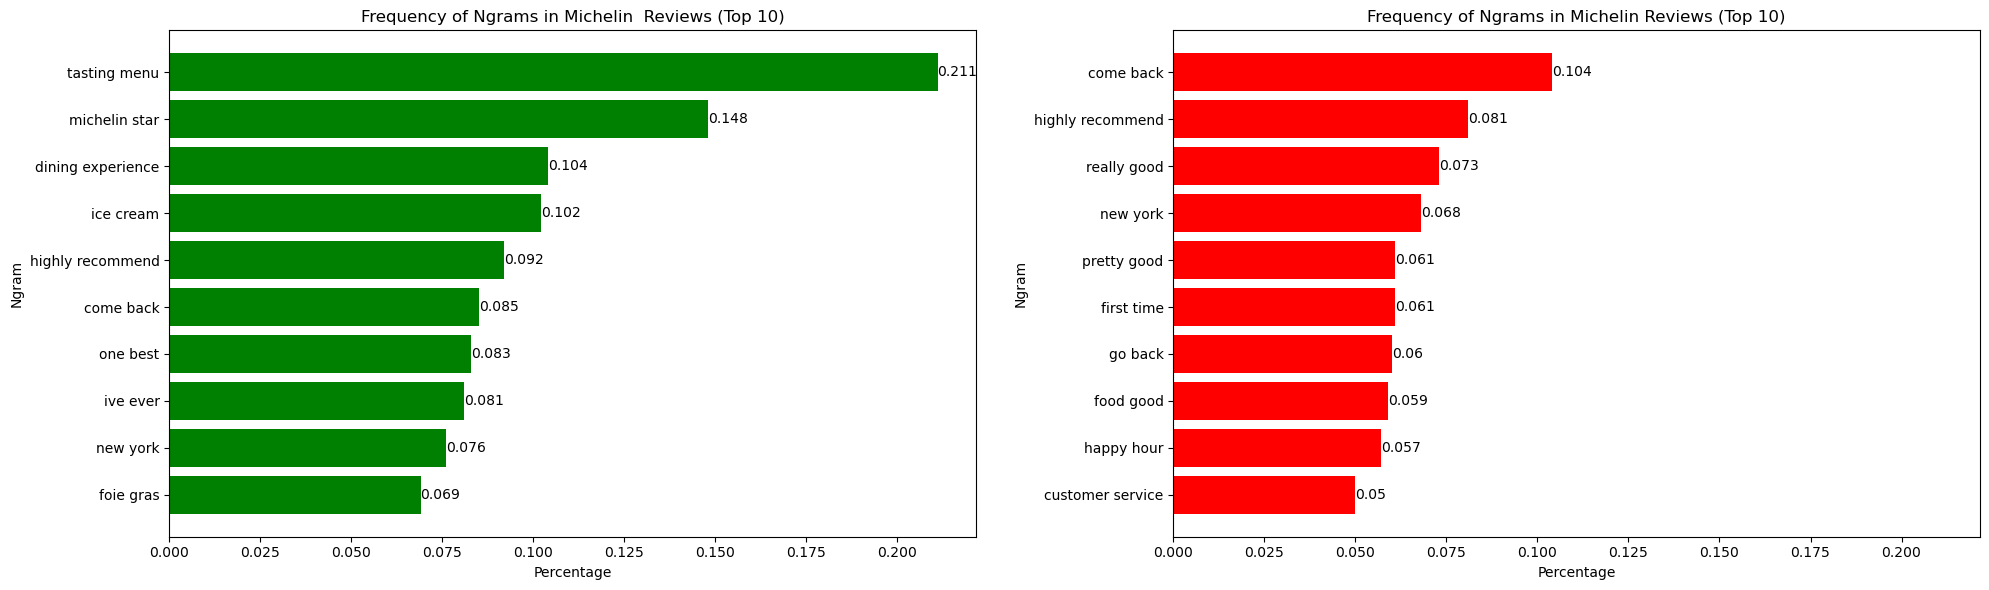

In [155]:
ngram_freq_plot(test_ng_nc, 'michelin')

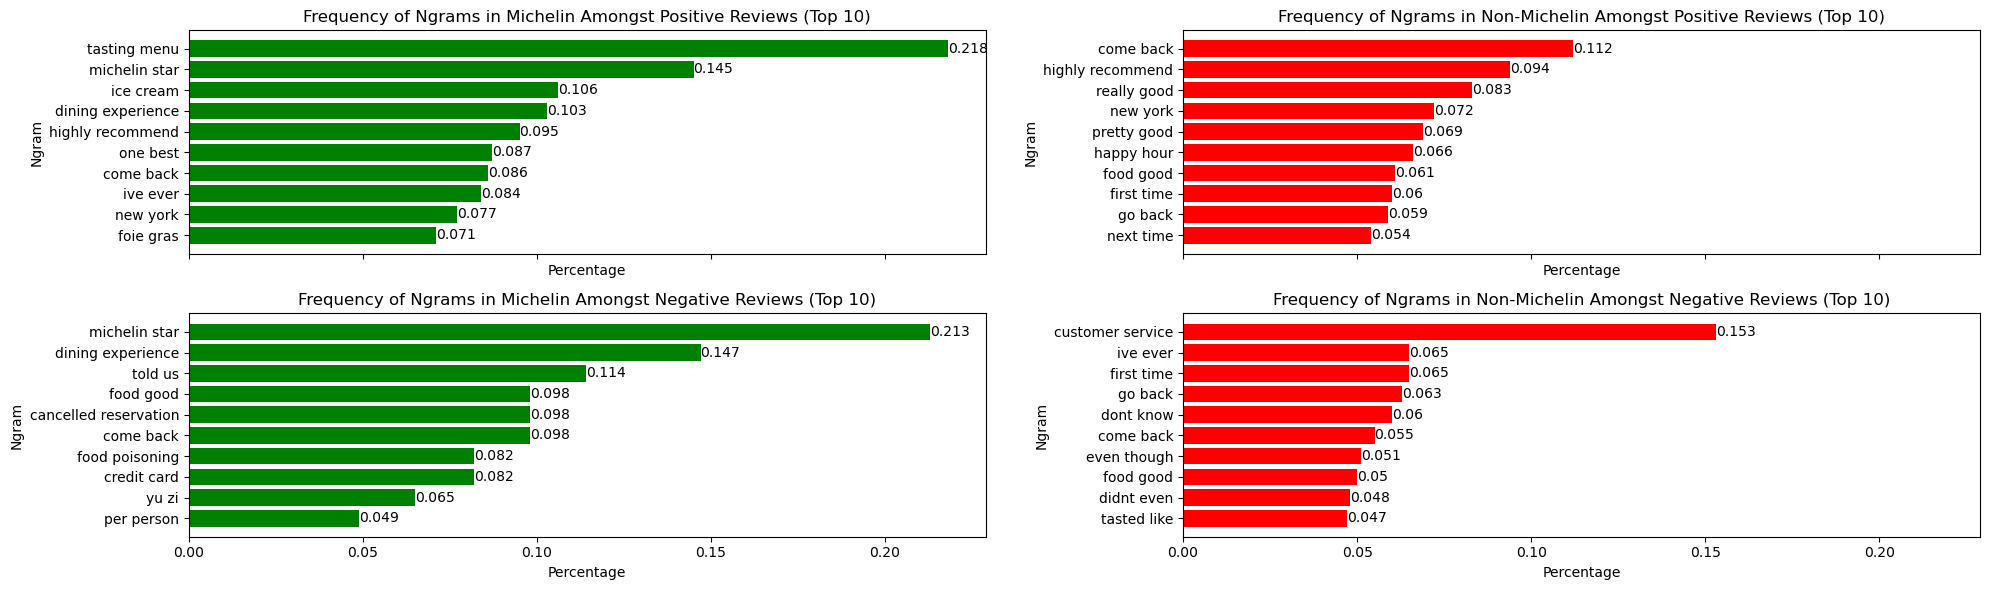

In [156]:
ngram_freq_plot(test_ng_c, 'michelin')

In [157]:
# Now get significance testing
def ngram_sig_test(freq_dfs):
    # Get population information
    if(len(freq_dfs) == 3):
        population = freq_dfs[2]
        pop_size = len(population)
    else:
        population = freq_dfs[4]
        pop_size = len(population)
    
    # Get information about truth case
    truth_size = len(freq_dfs[0])

    # Get dataframe of interest
    test = pd.merge(freq_dfs[0], population, on='Ngram')

    # Now see if there are significant results
    sig_list = []

    # Run the test for all values in our dataframe
    for index, val in test.iterrows():
        # Get successes
        truth = val['Frequency']
        pop = val['Frequency_Pop']

        # Conduct the test - this is not working
        p_val = proportions_ztest(np.array([truth, pop]), np.array([truth_size, pop_size]), alternative='larger')[1]

        if p_val < 0.01:
            sig_list.append(index)

    # Return matches with top words
    return freq_dfs[0].loc[sig_list][['Ngram', 'Frequency']]

In [158]:
test_ng_sig = ngram_sig_test(test_ng_nc)
test_ng_sig

,Ngram,Frequency
0,tasting menu,543
1,michelin star,380
2,dining experience,268
3,ice cream,262
4,highly recommend,235
5,come back,219
6,one best,213
7,ive ever,207
8,new york,195
9,foie gras,177


In [159]:
test_ng_sig = ngram_sig_test(test_ng_c)
test_ng_sig

,Ngram,Frequency
0,tasting menu,534
1,michelin star,355
2,ice cream,260
3,dining experience,252
4,highly recommend,234
5,one best,213
6,come back,210
7,ive ever,205
8,new york,189
9,foie gras,175
